# Метчинг товаров

Дано два множества объектов: множество A и множество B. Каждый объект в каждом множестве описывается определенными признаками. Цель состоит в том, чтобы для каждого объекта из множества A найти один или несколько объектов из множества B, которые схожи с ним по определенной метрике. Важно отметить, что множества A и B могут быть как различными, так и одинаковыми, и в процессе поиска соответствий может возникнуть ситуация, когда ни один объект из B не будет соответствовать объекту из A.

**Задача:**

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

- оценить качество алгоритма по метрике accuracy@5

# План по выполнению проекта
1. Загрузка данных
2. Предобработка и исследовательский анализ данных
3. Подготовка выборок для обучения
4. Разработатка ранжирующих моделей
5. Анализ моделей
6. Отчет по исследованию

# Исходные данные

- **base.csv** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.


- **train.csv** - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).


- **validation.csv** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv


- **validation_answer.csv** - правильные ответы к предыдущему файлу.

## Загрузка данных

### Импорт библиотек, создание функций

In [ ]:
!pip install -q faiss-cpu
!pip install -q scikit-learn

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#загрузка стандартных библиотек
import pandas as pd
import numpy as np

#графики
import seaborn as sns
from matplotlib import pyplot as plt

import re
from time import time

#предобработка данных
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Создание ранжирующих моделей
import faiss

# Подбор размера кластера
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#PCA
from sklearn import decomposition
from sklearn.decomposition import PCA


In [ ]:
# Информация о данных:
def info(data):
    '''
    Функция выводит информацию о данных, проверяет дубликаты и пропуски,
    выводит описательные статистики и гистограммы распределения для каждого столбца.

    Args:
    data : pandas.DataFrame - данные для анализа
    '''
    display(data.head())

    if not data.select_dtypes(include=['number']).columns.tolist():
        print("В наборе данных не найдено числовых столбцов для построения гистограмм")
    else:
        data.hist(figsize=(16, 12))
        plt.suptitle("Гистограмма распределения")
        plt.show()

    # Вывод информации о данных
    print("Информация о данных:")
    data.info()

    # Проверка на дубликаты
    if data.duplicated().sum() > 0:
        print("Найдены дубликаты в данных.")
    else:
        print("Дубликатов не найдено.")

    # Проверка на наличие пропусков
    if data.isnull().sum().any():
        print("Обнаружены пропуски в данных.")
    else:
        print("Пропуски отсутствуют.")

    # Вывод описательных статистик
    print("\nОписательные статистики:")
    display(data.describe())

In [ ]:
# переименование столбцов по рекомендациям PIP8
def rename_columns(df):
    df.columns = [re.sub('(?<!^)(?=[A-Z])', '_', col).lower() for col in df.columns]
    return df.columns

In [ ]:
#функция для поиска ближайших соседей с использованием FAISS
def find_nearest_neighbors(n_cells, nprobe_value, train_data, base_data):
    '''
    - n_cells: Количество кластеров для индексирования.
    - nprobe_value: Количество ближайших кластеров для поиска.
    - train_data: Обучающие данные, используемые для поиска ближайших соседей.
    - base_data: Базовые данные, используемые для построения индекса.
    '''

    # размерность векторного простанства
    dims = base_data.shape[1]

    # индекс для квантизации векторов
    # IndexFlatL2 измеряет L2 (или евклидово) расстояние между всеми заданными точками:
    # между вектором запроса и векторами, загруженными в индекс
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    #количество ближайших кластеров
    idx_l2.nprobe = nprobe_value
    idx_l2.train(np.ascontiguousarray(base_data[:50000, :]))
    idx_l2.add(np.ascontiguousarray(base_data))

    base_index = {k: v for k, v in enumerate(base_id.to_list())}
    #поиск ближайших соседей
    r, idx = idx_l2.search(train_data[:500, :], 5)

    acc = 0
    for target, el in zip(train_target.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    accuracy = 100 * acc / len(idx)

    return accuracy

In [ ]:
#код для перебора параметров
def process_nearest_neighbors(train2, base2):
    data = {
        'model': [],
        'n_cells': [],
        'n_nprobe': [],
        'model_time': [],
        'accuracy_result': []
    }

    n_cells_list = [50, 75, 100]
    idx_l2_nprobe_list = [5, 10, 15, 20, 25]

    for i in range(len(n_cells_list)):
        n_cells = n_cells_list[i]

        for j in range(len(idx_l2_nprobe_list)):
            idx_l2_nprobe = idx_l2_nprobe_list[j]

            start = time()
            accuracy_result = find_nearest_neighbors(n_cells, idx_l2_nprobe, train2, base2)
            end = time()
            model_time = round((end - start), 3)

            data['model'].append(f'model {i+1}-{j+1}')
            data['n_cells'].append(n_cells)
            data['n_nprobe'].append(idx_l2_nprobe)
            data['model_time'].append(model_time)
            data['accuracy_result'].append(accuracy_result)

            print(accuracy_result)

    return data

In [ ]:
#График логарифмированных значений параметров для каждой модели
def plot_log_values(df_sample1):
    models = range(1,16)

    n_cells_log = np.log10(df_sample1['n_cells'])
    idx_l2_nprobe_log = np.log10(df_sample1['n_nprobe'])
    model_time_log = np.log10([time * 10 for time in df_sample1['model_time']])
    accuracy_results_log = np.log10(df_sample1['accuracy_result'])

    plt.figure(figsize=(15, 5))
    plt.plot(models, n_cells_log, label='Number of Cells')
    plt.plot(models, idx_l2_nprobe_log, label='Number of Nprobe')
    plt.plot(models, model_time_log, label='Model Time x10')
    plt.plot(models, accuracy_results_log, label='Accuracy Result')

    plt.xlabel('Тип звезды')
    plt.ylabel('Логарифм медианного значения')
    plt.title('График логарифмированных значений параметров для каждой модели')
    plt.legend()
    plt.grid(True)

    plt.show()

### Загрузка данных

In [ ]:
links = ['base.csv', 'train.csv', 'validation.csv', 'validation_answer.csv']

links = ['base.csv', 'train.csv', 'validation.csv', 'validation_answer.csv']

data_dict = {}

for link in links:
    while True:
        try:
            file_name = link.split('.')[0]
            data = pd.read_csv(link)
            data_dict[file_name] = data
            break
        except (ValueError, FileNotFoundError):
            print(f'Ошибка при чтении файла: {link}')
            break

In [ ]:
base = data_dict['base']
train = data_dict['train']
validation = data_dict['validation']
validation_answer = data_dict['validation_answer']

# Предобработка и исследовательский анализ данных

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


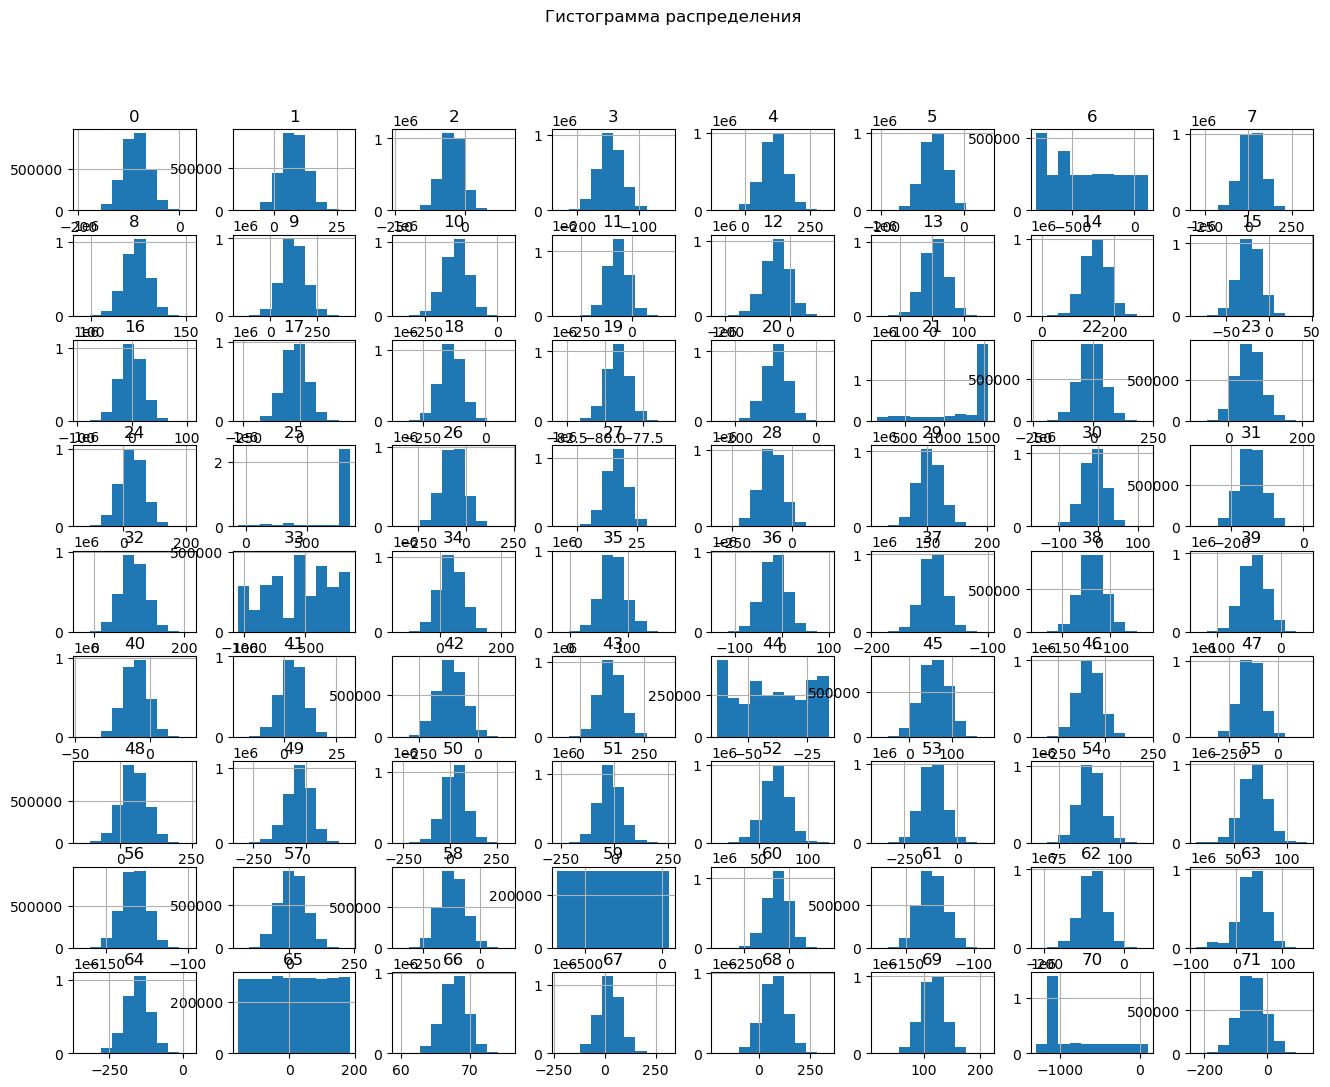

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,...,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,...,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,...,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,...,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.950944e+01,-2.331382e+02,-2.036016e+02,1.572448e+01,-1.297931e+03,-2.267801e+02
25%,-1.030654e+02,4.708491e+00,-6.955949e+01,-1.599051e+02,8.050795e+01,-9.137994e+01,-6.293318e+02,-2.222147e+01,1.194840e+02,8.176751e+01,...,-9.876390e+01,1.698862e+01,-1.807799e+02,-7.130038e+01,6.658096e+01,-1.251624e+01,3.377574e+01,1.016867e+02,-1.074465e+03,-7.566641e+01
50%,-8.623150e+01,8.038950e+00,-4.381661e+01,-1.467768e+02,1.118730e+02,-7.192230e+01,-4.222016e+02,2.080477e+01,1.238923e+02,1.234977e+02,...,-7.848812e+01,3.471502e+01,-1.539773e+02,1.382693e+01,6.781458e+01,2.341649e+01,7.492997e+01,1.160244e+02,-1.074465e+03,-4.859196e+01
75%,-6.925658e+01,1.147007e+01,-1.962527e+01,-1.333277e+02,1.423743e+02,-5.244111e+01,-1.566686e+02,6.391821e+01,1.279705e+02,1.672206e+02,...,-5.853355e+01,5.216429e+01,-1.273405e+02,9.966753e+01,6.902666e+01,5.975511e+01,1.158760e+02,1.295524e+02,-5.057445e+02,-1.971424e+01
max,2.151555e+01,2.993721e+01,1.609372e+02,-5.137478e+01,3.196645e+02,5.880624e+01,1.096325e+02,3.412282e+02,1.522612e+02,4.275421e+02,...,6.017411e+01,1.541678e+02,2.436099e+01,1.850981e+02,7.571203e+01,3.148988e+02,3.395738e+02,2.147063e+02,9.877081e+01,1.269732e+02


In [ ]:
info(base)

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


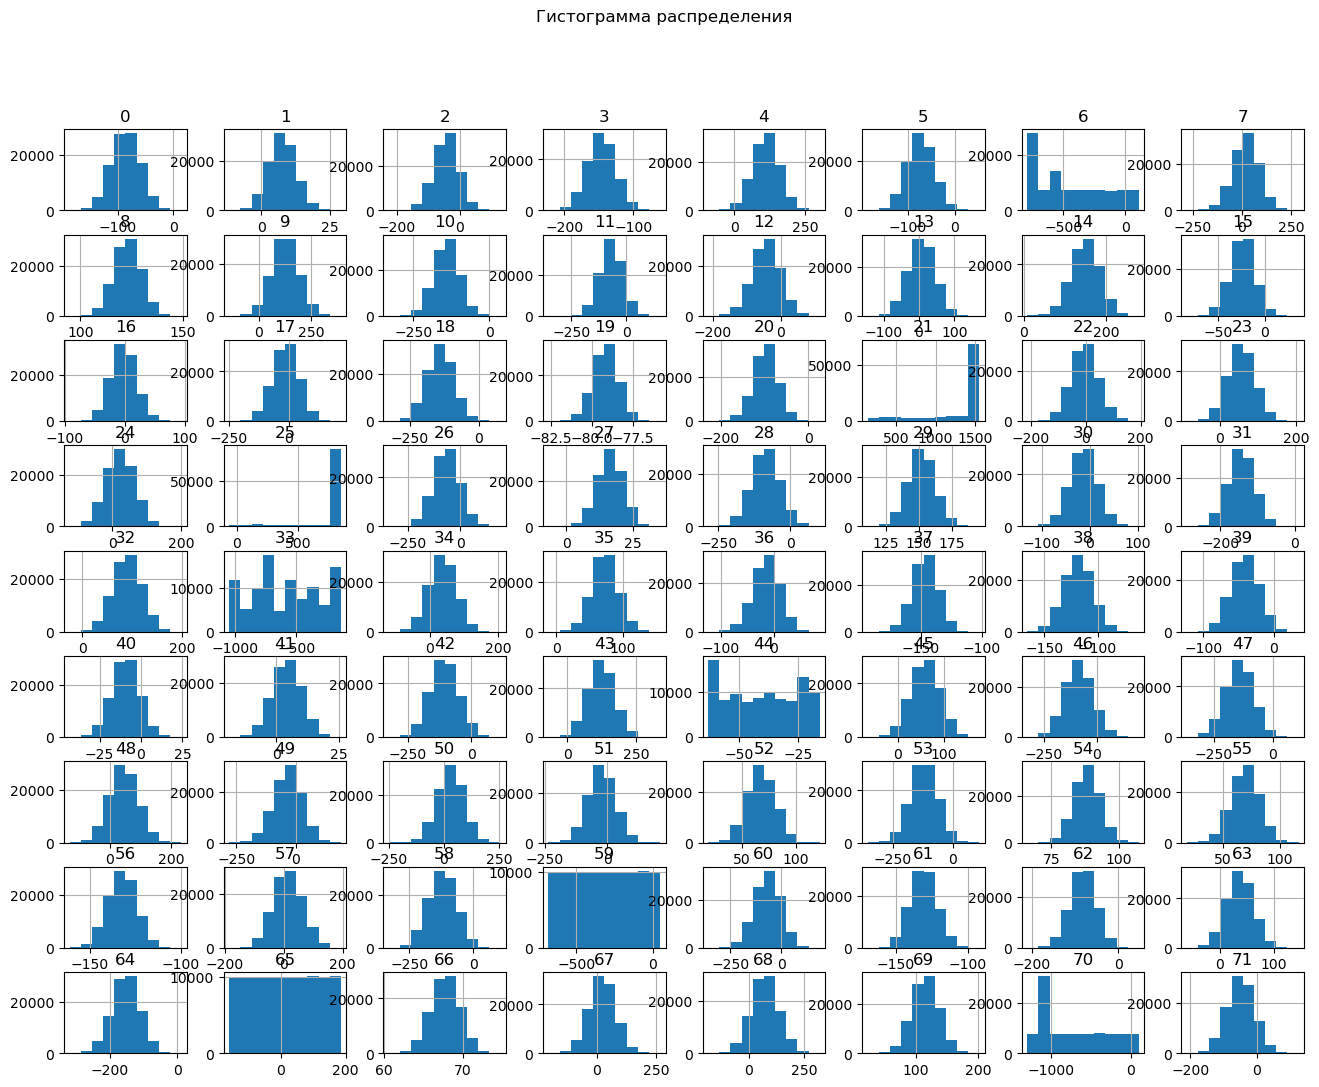

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  flo

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,...,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,...,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,...,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,...,-101.504830,19.774804,-178.929470,-71.745018,66.560655,-14.144571,31.685548,100.589324,-1074.464888,-76.478591
50%,-85.273695,7.652854,-42.830246,-146.067445,112.260100,-73.364420,-511.837758,22.278989,123.087540,125.963340,...,-80.859640,36.711365,-151.576985,14.072663,67.813585,23.441363,72.880192,115.236635,-808.801696,-48.700929
75%,-67.330810,10.981191,-17.713690,-132.277745,143.760830,-53.699612,-201.116578,65.899595,127.541802,169.701005,...,-60.492451,53.919520,-124.436974,100.011024,69.058750,59.941065,114.469224,129.791085,-357.087323,-20.487869
max,14.585236,28.917845,128.108460,-60.751625,301.363600,51.849710,109.625188,288.171840,149.356200,392.827150,...,47.733450,145.667130,11.907364,185.095137,74.779884,266.493320,319.867520,201.761260,98.768233,126.191790


In [ ]:
info(train)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


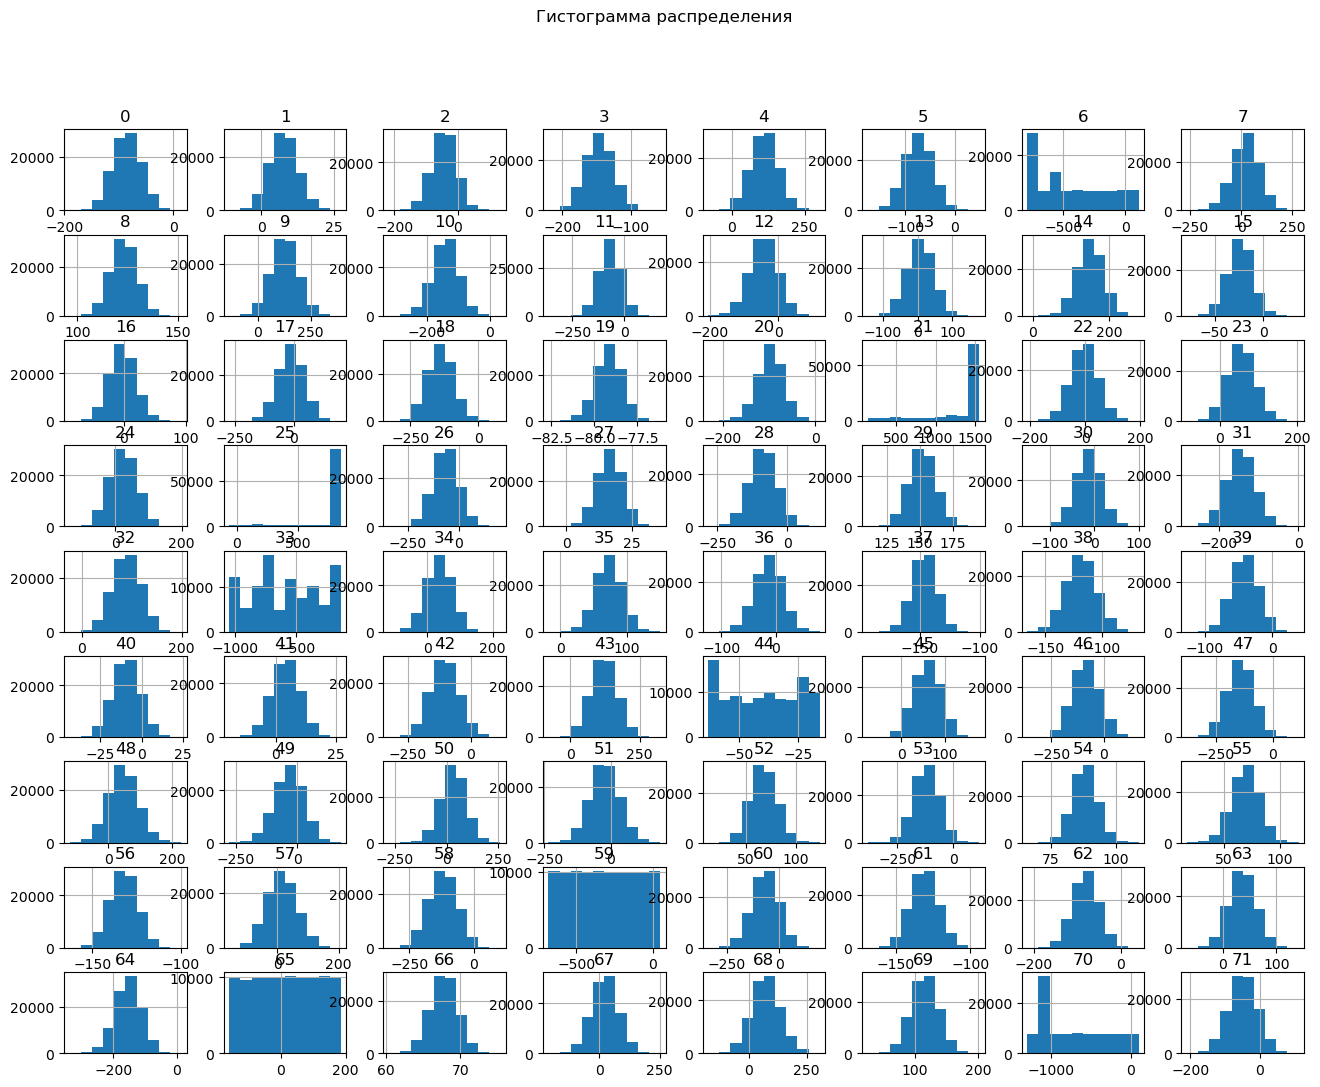

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  flo

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,...,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,...,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,...,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,...,-101.690472,19.564135,-179.115082,-70.420034,66.546130,-13.863008,31.494840,100.538862,-1074.464888,-76.359190
50%,-85.296745,7.657888,-43.230835,-146.080365,111.959330,-73.579283,-513.922978,22.138012,123.062568,126.083595,...,-81.027250,36.414150,-151.426035,14.768218,67.800445,23.508739,72.152398,115.280990,-807.029697,-48.670001
75%,-67.422104,10.993900,-17.765821,-132.119278,143.903735,-53.861139,-202.572440,66.097697,127.538967,169.680500,...,-60.274745,53.888420,-124.400438,99.803923,69.040832,60.154775,114.317053,129.770215,-358.400478,-20.283335
max,14.427986,27.409784,134.859800,-57.381890,302.065370,50.255325,109.632035,279.468900,151.822560,392.827150,...,41.390480,141.025270,14.602035,185.094333,75.400475,251.288590,305.937530,201.599980,98.737079,111.831955


In [ ]:
info(validation)

In [ ]:
info(validation_answer)

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


В наборе данных не найдено числовых столбцов для построения гистограмм
Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB
Дубликатов не найдено.
Пропуски отсутствуют.

Описательные статистики:


,Id,Expected
count,100000,100000
unique,100000,91502
top,100000-query,210304-base
freq,1,7


In [ ]:
# переименование столбцов
base.columns = rename_columns(base)
train.columns = rename_columns(train)
validation.columns = rename_columns(validation)
validation_answer.columns = rename_columns(validation_answer)

# проверка
print('base.columns:', base.columns)
print('train.columns:', train.columns)
print('validation.columns', validation.columns)
print('validation_answer.columns', validation_answer.columns)

base.columns: Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')
train.columns: Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47',
       '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59',
       '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       '

- Отсутствуют пропуски и дубликаты в данных
- Аномалии в данных не найдены
- Названия столбцов датафрейма переведены в соответствии с рекомендациями PEP 8
- В датасетах base, train и validation большинство столбцов имеют нормальное распределение, кроме столбцов 6, 21, 25, 33, 44, 59, 65, 70

# Разработатка ранжирующих моделей. FAISS

Для поиска ближайших соседей будет использоваться библиотека FAISS (Facebook AI Research Similarity Search) – разработка команды Facebook AI Research для быстрого поиска ближайших соседей и кластеризации в векторном пространстве. Благодаря высокой скорости поиска возможно работать с очень большими данными, включая несколько миллиардов векторов.

Для решения задачи будут созданы три выбрки:
1. Первая выборка содержит исходные датасеты без изменения.
2. Вторая выборка включает только признаки с нормальным распределением, исключая столбцы: 6, 21, 25, 33, 44, 59, 65, 70.
3. Третья выборка содержит признаки первых двух выборок, преобразованные с использованием метода главных компонент (PCA). Будет рассмотрено различное количество компонент.
Для каждой выборки будет производиться перебор размера кластера и количества ближайших кластеров.

Изначально планировалось использовать цикл для перебора наилучшего размера кластера. Однако расчёт проходил слишком медленно, поэтому я рассмотрю всего лишь 3 размера кластера: 50, 75 и 100. Увеличение размера кластера свыше 100 существенно увеличивало время расчёта. Также я проведу перебор количества ближайших кластеров: 5, 10, 15, 20, 25.
Поиск ближайших соседей будет происходить только для первых 500 строк тренировочной выборки для снижения времени расчетов.

   
    best_score = -1
    best_cluster_size = 0

    for n_clusters in range(50, 251, 15):
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(base1)
        silhouette_avg = silhouette_score(base1, cluster_labels)
    
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_cluster_size = n_clusters

    print("Лучший размер кластера на основе Silhouette Score:", best_cluster_size)
    

In [ ]:
#сохраняю id, target, expected
base_id = base['id']
train_id = train['id']
train_target = train['target']
validation_id = validation['id']
validation_answer_expected = validation_answer['expected']

## Sample1

Первая выборка содержит исходные датасеты без изменений. Будет проанализировано количество кластеров и количество ближайших кластеров для поиска.

### Подготовка данных Sample1

In [ ]:
base1 = base.drop(columns=['id'], axis=1).copy()
train1 = train.drop(columns=['id', 'target'], axis=1).copy()
validation1 = validation.drop(columns=['id'], axis=1).copy()

In [ ]:
num_col = base1.columns.tolist()

# Создание ColumnTransformer для масштабирования признаков
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), num_col)
])

In [ ]:
# Масштабирование данных с помощью ColumnTransformer
base1 = column_transformer.fit_transform(base1)
train1 = column_transformer.transform(train1)
validation1 = column_transformer.transform(validation1)
print('нулевой элемент base:', base1[0])
print('нулевой элемент train:', train1[0])

нулевой элемент base: [-1.15921621  0.62035039 -0.51372266  1.39855776  2.26904345 -1.16038496
 -0.28288362  0.37366256 -0.43562659  0.88454365  0.4576469   0.73073908
 -0.41463426  0.78201584  1.00285473 -0.37510107 -0.20510187  0.33189056
  0.99042818 -0.36617164 -0.2019014   0.62431793 -0.49577625 -0.1530666
 -2.01843422  0.42159108  0.40135749 -1.69555507 -0.89876331 -0.29430765
  0.05313913  0.03532411 -0.26462494  0.06513401 -0.83885471  1.69344411
  0.80234648 -0.67295311 -0.38906162  0.1131067  -0.40123943 -1.40868981
 -0.70640697 -0.96219636 -1.19775652 -1.29778618 -0.22126234  0.00696112
  0.9529048  -2.37308311 -1.29941832  1.57543507  0.84989106  0.52136797
  0.28986782  0.88773797  0.43402009 -1.13324375  0.70881925  1.52490547
  0.00679186 -0.84751261  1.18904887  0.19052392  0.07358854 -0.89478931
 -2.26249347 -0.51043767  0.29300367 -0.0140507   1.78141979 -0.31232868]
нулевой элемент train: [ 1.29951853  1.99688841  0.06377414 -1.87967059  1.64409957 -0.53762577
  0.16

In [ ]:
# Меняю тип данных
base1 = base1.astype('float32')
train1 = train1.astype('float32')
validation1 = validation1.astype('float32')

### Поиск ближайших соседей для Sample1

In [ ]:
df_sample1 = process_nearest_neighbors(train1, base1)

65.4
65.8
66.0
66.6
66.6
65.8
66.0
66.0
66.2
66.2
64.8
65.8
66.0
66.0
66.0


### Анализ моделей Sample1

In [ ]:
# Выводим таблицу результатов
df_sample1 = pd.DataFrame(df_sample1)
df_sample1['sample'] = 'sample1'
print(df_sample1)

        model  n_cells  n_nprobe  model_time  accuracy_result   sample
0   model 1-1       50         5       3.417             65.4  sample1
1   model 1-2       50        10       5.450             65.8  sample1
2   model 1-3       50        15       7.464             66.0  sample1
3   model 1-4       50        20       9.515             66.6  sample1
4   model 1-5       50        25      11.219             66.6  sample1
5   model 2-1       75         5       3.018             65.8  sample1
6   model 2-2       75        10       4.516             66.0  sample1
7   model 2-3       75        15       6.108             66.0  sample1
8   model 2-4       75        20       7.143             66.2  sample1
9   model 2-5       75        25       8.426             66.2  sample1
10  model 3-1      100         5       2.973             64.8  sample1
11  model 3-2      100        10       4.272             65.8  sample1
12  model 3-3      100        15       5.658             66.0  sample1
13  mo

In [ ]:
df_sample1.sort_values(by=['accuracy_result',
                           'model_time'],ascending=[False, True])

,model,n_cells,n_nprobe,model_time,accuracy_result,sample
3,model 1-4,50,20,9.515,66.6,sample1
4,model 1-5,50,25,11.219,66.6,sample1
8,model 2-4,75,20,7.143,66.2,sample1
9,model 2-5,75,25,8.426,66.2,sample1
6,model 2-2,75,10,4.516,66.0,sample1
12,model 3-3,100,15,5.658,66.0,sample1
13,model 3-4,100,20,5.889,66.0,sample1
7,model 2-3,75,15,6.108,66.0,sample1
14,model 3-5,100,25,7.363,66.0,sample1
2,model 1-3,50,15,7.464,66.0,sample1


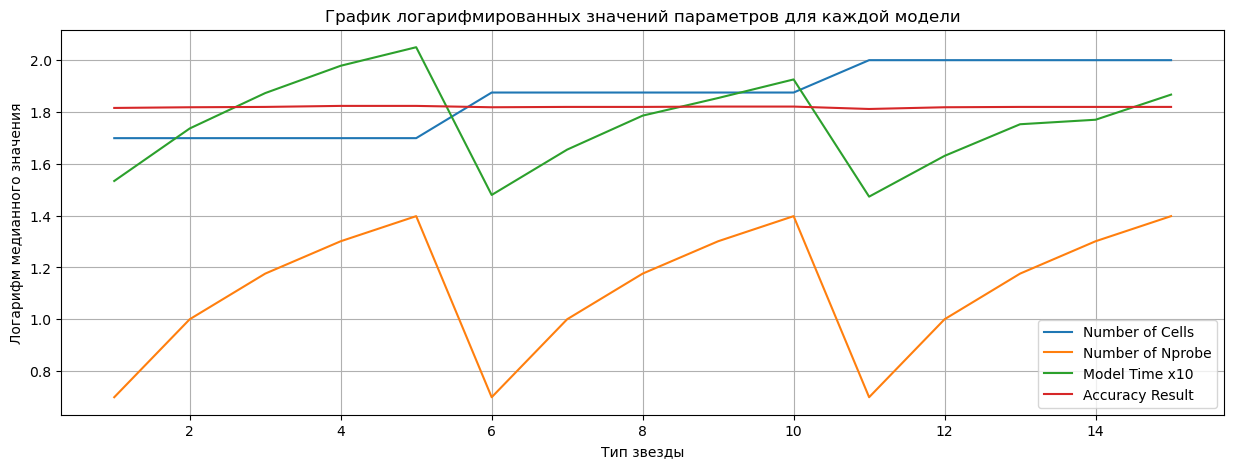

In [ ]:
plot_log_values(df_sample1)

1. С увеличением значения параметра n_cells (количество кластеров для индексирования) время работы модели снижается. Например, при увеличении n_cells с 50 до 100 время работы модели сокращается в среднем в 1.1 раз при n_nprobe равным 5.

Это может быть связано с тем, что увеличение количества кластеров позволяет более эффективно организовать данные для поиска ближайших соседей, что в свою очередь может ускорить процесс поиск Но при этом, при увеличении параметра n_cells на своем ноутбуке свыше 100 - расчет задачи увеличивался на неопределенно длительное время.

2. Увеличение значения n_nprobe обычно приводит к повышению точности модели, хотя некоторые изменения могут быть незначительными. Например, при увеличении n_nprobe с 5 до 25 точность увеличивается с 65.4% до 66.6% для n_cells равным 50. При увеличении параметра n_nprobe увеличивается и время расчета. Например:
    -  при увеличении n_nprobe с 5 до 25 время работы модели увеличивается в 3.2 раз при n_cells равным 50.
    -  при увеличении n_nprobe с 5 до 25 время работы модели увеличивается в 2.7 раз при n_cells равным 75.
    -  при увеличении n_nprobe с 5 до 25 время работы модели увеличивается в 2.5 раз при n_cells равным 100.
   
Это может свидетельствовать о том, что при более низких значениях n_cells увеличение количества ближайших кластеров n_nprobe оказывает более существенное влияние на производительность модели, приводя к увеличению времени работы в большей степени, чем при более высоких значениях n_cells.

3. Максимальное accuracy равно 66.6, достигается при n_cells = 50 и при n_nprobe равным 20 и 25. При n_nprobe = 20, расчет занимает в 1.2 раза меньше времени 5.о.

## Sample2

Вторая выборка включает только признаки с нормальным распределением, исключая столбцы: 6, 21, 25, 33, 44, 59, 65, 70.

### Подготовка данных Sample2

In [ ]:
base2 = base.drop(columns={'id', '6', '21', '25', '33', '44', '59', '65', '70'}, axis = 1).copy()
train2 = train.drop(columns={'id', 'target',  '6', '21', '25', '33', '44', '59', '65', '70'}, axis = 1).copy()
validation2 = validation.drop(columns={'id', '6', '21', '25', '33', '44', '59', '65', '70'}, axis = 1).copy()

In [ ]:
num_col = base2.columns.tolist()

# Создание ColumnTransformer для масштабирования признаков
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), num_col)
])

In [ ]:
# Масштабирование данных с помощью ColumnTransformer
base2 = column_transformer.fit_transform(base2)
train2 = column_transformer.transform(train2)
validation2 = column_transformer.transform(validation2)
print('нулевой элемент base:', base2[0])
print('нулевой элемент train:', train2[0])

нулевой элемент base: [-1.15921621  0.62035039 -0.51372266  1.39855776  2.26904345 -1.16038496
  0.37366256 -0.43562659  0.88454365  0.4576469   0.73073908 -0.41463426
  0.78201584  1.00285473 -0.37510107 -0.20510187  0.33189056  0.99042818
 -0.36617164 -0.2019014  -0.49577625 -0.1530666  -2.01843422  0.40135749
 -1.69555507 -0.89876331 -0.29430765  0.05313913  0.03532411 -0.26462494
 -0.83885471  1.69344411  0.80234648 -0.67295311 -0.38906162  0.1131067
 -0.40123943 -1.40868981 -0.70640697 -0.96219636 -1.29778618 -0.22126234
  0.00696112  0.9529048  -2.37308311 -1.29941832  1.57543507  0.84989106
  0.52136797  0.28986782  0.88773797  0.43402009 -1.13324375  0.70881925
  0.00679186 -0.84751261  1.18904887  0.19052392  0.07358854 -2.26249347
 -0.51043767  0.29300367 -0.0140507  -0.31232868]
нулевой элемент train: [ 1.29951853  1.99688841  0.06377414 -1.87967059  1.64409957 -0.53762577
  0.27959806 -2.29679437 -1.45962619  1.32070992  0.33563286  0.34833787
 -0.074182    1.46757774 -0.52

In [ ]:
base2 = base2.astype('float32')
train2 = train2.astype('float32')
validation2 = validation2.astype('float32')

### Поиск ближайших соседей для Sample2

In [ ]:
df_sample2 = process_nearest_neighbors(train2, base2)

69.6
70.4
70.8
70.8
70.8
69.0
69.6
70.0
70.2
70.4
69.2
70.0
70.4
70.4
70.4


### Анализ моделей Sample2

In [ ]:
# Выводим таблицу результатов
df_sample2 = pd.DataFrame(df_sample2)
df_sample2['sample'] = 'sample2'
print(df_sample2)

        model  n_cells  n_nprobe  model_time  accuracy_result   sample
0   model 1-1       50         5       3.383             69.6  sample2
1   model 1-2       50        10       5.313             70.4  sample2
2   model 1-3       50        15       6.903             70.8  sample2
3   model 1-4       50        20       8.338             70.8  sample2
4   model 1-5       50        25      10.079             70.8  sample2
5   model 2-1       75         5       2.738             69.0  sample2
6   model 2-2       75        10       3.970             69.6  sample2
7   model 2-3       75        15       5.226             70.0  sample2
8   model 2-4       75        20       6.698             70.2  sample2
9   model 2-5       75        25       7.685             70.4  sample2
10  model 3-1      100         5       2.724             69.2  sample2
11  model 3-2      100        10       3.478             70.0  sample2
12  model 3-3      100        15       4.547             70.4  sample2
13  mo

In [ ]:
df_sample2.sort_values(by=['accuracy_result',
                           'model_time'],ascending=[False, True])

,model,n_cells,n_nprobe,model_time,accuracy_result,sample
2,model 1-3,50,15,6.903,70.8,sample2
3,model 1-4,50,20,8.338,70.8,sample2
4,model 1-5,50,25,10.079,70.8,sample2
12,model 3-3,100,15,4.547,70.4,sample2
13,model 3-4,100,20,5.263,70.4,sample2
1,model 1-2,50,10,5.313,70.4,sample2
14,model 3-5,100,25,6.056,70.4,sample2
9,model 2-5,75,25,7.685,70.4,sample2
8,model 2-4,75,20,6.698,70.2,sample2
11,model 3-2,100,10,3.478,70.0,sample2


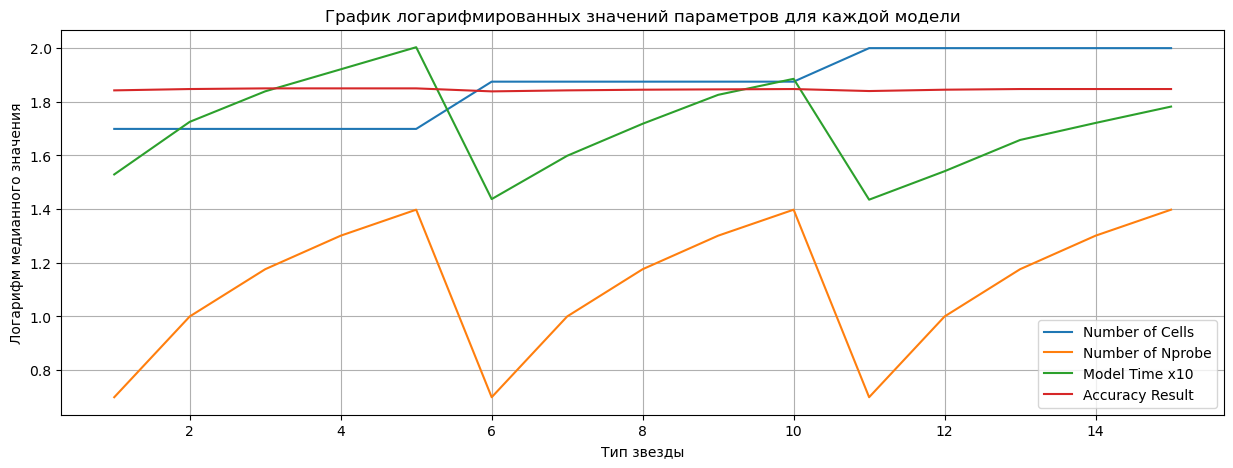

In [ ]:
plot_log_values(df_sample2)

Максимальное accuracy равно 70.8, достигается при n_cells = 50 и при n_nprobe равным 15, 20 и 25. Минимальное время для данного значения кластеров, достигается при n_nprobe = 15

Анализ признаков и последующее удаление признаков с ненормальным распределением увеличило метрику accuracy с 66.6 до 70.8

## Sample3

Третья выборка содержит признаки из первых двух выборок, преобразованные с использованием метода главных компонент (PCA). Будет рассмотрено различное количество компонентов.

### Подготовка данных Sample3

Необходимо проанализировать, сколько компонентов лучше оставить для датасетов. Для анализа использую все промасштабированные признаки из train1 и train2

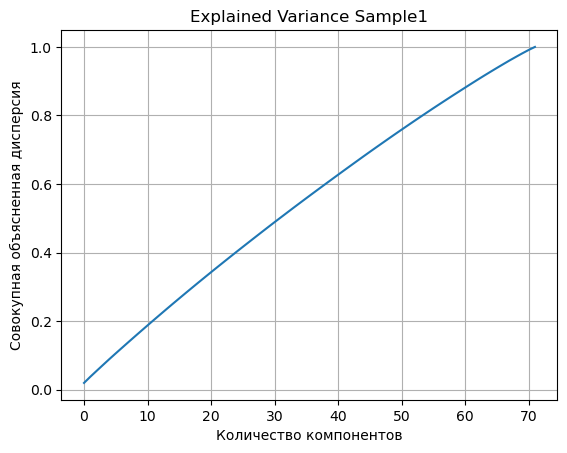

In [ ]:
pca_cat = PCA()

pca_cat.fit(train1)

plt.plot(np.cumsum(pca_cat.explained_variance_ratio_))
plt.xlabel('Количество компонентов')
plt.ylabel('Совокупная объясненная дисперсия')
plt.title('Explained Variance Sample1')
plt.grid()
plt.show()

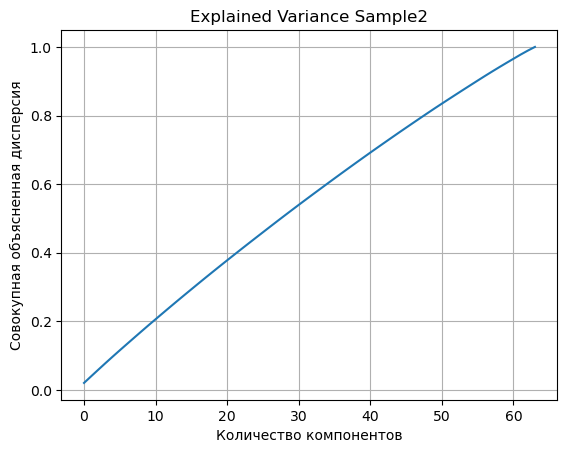

In [ ]:
pca_cat = PCA()

pca_cat.fit(train2)

plt.plot(np.cumsum(pca_cat.explained_variance_ratio_))
plt.xlabel('Количество компонентов')
plt.ylabel('Совокупная объясненная дисперсия')
plt.title('Explained Variance Sample2')
plt.grid()
plt.show()

Первая выборка имеет 72 признака. Вторая - 64 признака.

Для первой выборки:
 - 40 компонентов объясняет чуть больше 60% данных
 - 50 компонентов - чуть меньше 80%
Для второй выборки:
 - 40 компонентов объясняет 70% данных
 - 50 компонентов - чуть больше 80%

График Explained Variance, который двигается практически пропорционально увеличению количества компонентов после применения PCA, говорит о том, что каждая дополнительная компонента объясняет дополнительную дисперсию в данных. То есть, принаки к датасетах достаточно равнозначны. Добавление большего количества компонентов помогает сохранить больше информации из исходных данных.

Я собираюсь снизить дисперсию на 20-40% и посмотреть, как сильно это повлияет на метрику и время расчета данных

#### Преобразование данных из Sample1

In [ ]:
pca_40 = PCA(n_components=40, svd_solver='arpack')
base1_pca_40 = pca_40.fit(base1)
base1_pca_40 = pca_40.transform(base1)
train1_pca_40 =pca_40.transform(train1)
validation1_pca_40 = pca_40.transform(validation1)

In [ ]:
pca_50 = PCA(n_components=50, svd_solver='arpack')
base1_pca_50 = pca_50.fit(base1)
base1_pca_50 = pca_50.transform(base1)
train1_pca_50 = pca_50.transform(train1)
validation1_pca_50 = pca_50.transform(validation1)

#### Преобразование данных из Sample2

In [ ]:
base2_pca_40 = pca_40.fit(base2)
base2_pca_40 = pca_40.transform(base2)
train2_pca_40 =pca_40.transform(train2)
validation2_pca_40 = pca_40.transform(validation2)

In [ ]:
base2_pca_50 = pca_50.fit(base2)
base2_pca_50 = pca_50.transform(base2)
train2_pca_50 = pca_50.transform(train2)
validation2_pca_50 = pca_50.transform(validation2)

### Поиск для Sample1 c PCA(n_components=40)

In [ ]:
df_sample1_pca_40 = process_nearest_neighbors(train1_pca_40, base1_pca_40)

58.2
58.6
58.8
59.2
59.2
57.6
58.6
58.8
59.2
59.2
57.8
58.6
58.8
59.0
59.0


### Поиск для Sample1 c PCA(n_components=50)

In [ ]:
df_sample1_pca_50 = process_nearest_neighbors(train1_pca_50, base1_pca_50)

62.4
63.0
63.6
63.6
63.6
62.8
63.6
63.8
63.6
63.6
62.4
63.2
63.6
63.6
63.6


### Поиск для Sample2 c PCA(n_components=40)

In [ ]:
df_sample2_pca_40 = process_nearest_neighbors(train2_pca_40, base2_pca_40)

66.8
68.0
68.6
68.6
68.6
67.6
68.4
68.6
68.6
68.6
67.6
68.2
68.2
68.6
68.8


### Поиск для Sample2 c PCA(n_components=50)

In [ ]:
df_sample2_pca_50 = process_nearest_neighbors(train2_pca_50, base2_pca_50)

69.2
69.8
69.8
70.0
70.4
69.2
70.0
70.2
70.2
70.2
67.4
69.4
69.8
69.8
70.2


### Анализ моделей Sample3

In [ ]:
# Выводим таблицу результатов
df_sample1_pca_40 = pd.DataFrame(df_sample1_pca_40)
df_sample1_pca_40['sample'] = 'sample1_pca_40'

df_sample1_pca_50 = pd.DataFrame(df_sample1_pca_50)
df_sample1_pca_50['sample'] = 'sample1_pca_50'

df_sample2_pca_40 = pd.DataFrame(df_sample2_pca_40)
df_sample2_pca_40['sample'] = 'sample2_pca_40'

df_sample2_pca_50 = pd.DataFrame(df_sample2_pca_50)
df_sample2_pca_50['sample'] = 'sample2_pca_50'

#соединяю датасеты
results_sample_pca = pd.concat([df_sample1_pca_40,
                                df_sample1_pca_50,
                                df_sample2_pca_40,
                                df_sample2_pca_50], axis=0)

display(results_sample_pca)

,model,n_cells,n_nprobe,model_time,accuracy_result,sample
0,model 1-1,50,5,2.028,58.2,sample1_pca_40
1,model 1-2,50,10,3.331,58.6,sample1_pca_40
2,model 1-3,50,15,4.207,58.8,sample1_pca_40
3,model 1-4,50,20,5.042,59.2,sample1_pca_40
4,model 1-5,50,25,6.076,59.2,sample1_pca_40
5,model 2-1,75,5,1.625,57.6,sample1_pca_40
6,model 2-2,75,10,2.224,58.6,sample1_pca_40
7,model 2-3,75,15,3.021,58.8,sample1_pca_40
8,model 2-4,75,20,3.738,59.2,sample1_pca_40
9,model 2-5,75,25,4.142,59.2,sample1_pca_40


In [ ]:
results_sample_pca.sort_values(by=['accuracy_result','model_time'],ascending=[False, True])

,model,n_cells,n_nprobe,model_time,accuracy_result,sample
4,model 1-5,50,25,7.307,70.4,sample2_pca_50
7,model 2-3,75,15,3.724,70.2,sample2_pca_50
8,model 2-4,75,20,4.403,70.2,sample2_pca_50
14,model 3-5,100,25,4.779,70.2,sample2_pca_50
9,model 2-5,75,25,5.013,70.2,sample2_pca_50
6,model 2-2,75,10,2.724,70.0,sample2_pca_50
3,model 1-4,50,20,6.205,70.0,sample2_pca_50
12,model 3-3,100,15,3.357,69.8,sample2_pca_50
1,model 1-2,50,10,3.632,69.8,sample2_pca_50
13,model 3-4,100,20,3.651,69.8,sample2_pca_50


Лучший результат достигнут с accuracy=70.4 при снижении дисперсии примерно на 20% с количеством компонент равным 50 для выборки, в которой были удалены признаки с ненормальным распределением.
Параметры n_cells = 50, n_nprobe = 25. Время работы модели с такими же параметрами снизилась в 1.4 раза, а метрика снизилась на 0.4%.
При сравнении с лучшей моделью из второй выборки с параметрами n_cells = 50, n_nprobe = 15, метрика упала с 70.8% до 69.8%, время работы снизилась в 2 раза.

# Анализ моделей

In [ ]:
#соединяю данные 3 лучшей моделей из каждой выборки
results_end = pd.concat([df_sample1.sort_values(by=['accuracy_result','model_time'],ascending=[False, True]).head(3),
                                df_sample2.sort_values(by=['accuracy_result','model_time'],ascending=[False, True]).head(3),
                                results_sample_pca.sort_values(by=['accuracy_result','model_time'],ascending=[False, True]).head(3)], axis=0)

In [ ]:
results_end.sort_values(by=['accuracy_result','model_time'],ascending=[False, True])

,model,n_cells,n_nprobe,model_time,accuracy_result,sample
2,model 1-3,50,15,6.903,70.8,sample2
3,model 1-4,50,20,8.338,70.8,sample2
4,model 1-5,50,25,10.079,70.8,sample2
4,model 1-5,50,25,7.307,70.4,sample2_pca_50
7,model 2-3,75,15,3.724,70.2,sample2_pca_50
8,model 2-4,75,20,4.403,70.2,sample2_pca_50
3,model 1-4,50,20,9.515,66.6,sample1
4,model 1-5,50,25,11.219,66.6,sample1
8,model 2-4,75,20,7.143,66.2,sample1


Лучше всего показали себя модели из второй выборки и модели из той же выборки, но проведенные через PCA() со снижением дисперсии на 20%.
Наиболее высокий показатель accuracy = 70.8% с оптимальным количеством времени обучения - достигнут для второй выборки с n_cells = 50 и n_nprobe = 15

# Отчет по исследованию

1. Выводы в результате предобработки и анализа данных:

- Отсутствуют пропуски и дубликаты в данных
- Аномалии в данных не найдены
- Названия столбцов датафрейма переведены в соответствии с рекомендациями PEP 8
- В датасетах base, train и validation большинство столбцов имеют нормальное распределение, кроме столбцов 6, 21, 25, 33, 44, 59, 65, 70

2. Для поиска ближайших соседей использовалась библиотека FAISS.

   Для решения задачи созданы три выборки:
   - Первая выборка содержит исходные датасеты без изменений.
   - Вторая выборка включает только признаки с нормальным распределением, исключая столбцы: 6, 21, 25, 33, 44, 59, 65, 70.
   - Третья выборка содержит признаки из первых двух выборок, преобразованные с использованием метода главных компонент (PCA). Будет рассмотрено различное количество компонентов.

Для каждой выборки был произведен перебор размера кластера и количества ближайших кластеров.

Изначально планировалось использовать цикл для перебора наилучшего размера кластера. Однако расчёт проходил слишком медленно, поэтому были расмотрены всего 3 размера кластера: 50, 75 и 100. Увеличение размера кластера свыше 100 существенно увеличивало время расчёта. Также проведен перебор количества ближайших кластеров: 5, 10, 15, 20, 25.
Поиск ближайших соседей происходил только для первых 500 строк тренировочной выборки для снижения времени расчета.

3. После проведения расчета для первой выборки, были замечены следующие закономерности:

- С увеличением значения параметра n_cells (количество кластеров для индексирования) время работы модели снижается. Например, при увеличении n_cells с 50 до 100 время работы модели сокращается в среднем в 1.1 раз при n_nprobe равным 5.

Это может быть связано с тем, что увеличение количества кластеров позволяет более эффективно организовать данные для поиска ближайших соседей, что в свою очередь может ускорить процесс поиска. Но при этом, при увеличении параметра n_cells на своем ноутбуке свыше 100 - расчет задачи увеличивался на неопределенно длительное время.

- Увеличение значения n_nprobe обычно приводит к повышению точности модели, хотя некоторые изменения могут быть незначительными. Например, при увеличении n_nprobe с 5 до 25 точность увеличивается с 65.4% до 66.6% для n_cells равным 50. При увеличении параметра n_nprobe увеличивается и время расчета. Например:
    -  при увеличении n_nprobe с 5 до 25 время работы модели увеличивается в 3.2 раз при n_cells равным 50.
    -  при увеличении n_nprobe с 5 до 25 время работы модели увеличивается в 2.7 раз при n_cells равным 75.
    -  при увеличении n_nprobe с 5 до 25 время работы модели увеличивается в 2.5 раз при n_cells равным 100.
   
Это может свидетельствовать о том, что при более низких значениях n_cells увеличение количества ближайших кластеров n_nprobe оказывает более существенное влияние на производительность модели, приводя к увеличению времени работы в большей степени, чем при более высоких значениях n_cells.

4. Для первой выборки максимальное accuracy равно 66.6, достигается при n_cells = 50 и при n_nprobe равным 20 и 25. При n_nprobe = 20, расчет занимает в 1.2 раза меньше времени
5. В результате расчета над второй выборкой были сделаны следующие выводы:
   
   - Максимальное accuracy равно 70.8, достигается при n_cells = 50 и при n_nprobe равным 15, 20 и 25. Минимальное время для данного значения кластеров, достигается при n_nprobe = 15

   - Анализ признаков и последующее удаление признаков с ненормальным распределением увеличило метрику accuracy с 66.6 до 70.8
  
6. При изучении Explained Variance для двух выше перечисленных выборок, были сделаны выводы:

- Для первой выборки:
     - 40 компонентов объясняет чуть больше 60% данных
     - 50 компонентов - чуть меньше 80%
- Для второй выборки:
     - 40 компонентов объясняет 70% данных
     - 50 компонентов - чуть больше 80%

График Explained Variance, который двигается практически пропорционально увеличению количества компонентов после применения PCA, говорит о том, что каждая дополнительная компонента объясняет дополнительную дисперсию в данных. То есть, принаки к датасетах достаточно равнозначны. Добавление большего количества компонентов помогает сохранить больше информации из исходных данных.

7. Лучший результат для данных проведенных через PCA() - достигнут с accuracy=70.4 при снижении дисперсии примерно на 20% с количеством компонент равным 50 для выборки, в которой были удалены признаки с ненормальным распределением.
Параметры: n_cells = 50, n_nprobe = 25. Время работы модели с такими же параметрами снизилась в 1.4 раза, а метрика снизилась на 0.4%.При сравнении с лучшей моделью из второй выборки с параметрами n_cells = 50, n_nprobe = 15, метрика упала с 70.8% до 69.8%, время работы снизилась в 2 раза.

8. По итогу, лучше всего показали себя модели из второй выборки и модели из той же выборки, но проведенные через PCA() со снижением дисперсии на 20%.
Наиболее высокий показатель accuracy = 70.8% с оптимальным количеством времени обучения - достигнут для второй выборки с n_cells = 50 и n_nprobe = 15.

 Получается, что лучший результат достигается при изначальной правильной обработке данных. И только потом на время обучения и метрику может повлиять правильный набор гиперпараметров. Использование PCA() для обработки данных может снизить длительность расчета при незначительном снижении метрики - с разницей в десятых долях, - если использовать для анализа несколько моделей с разным количеством параметров.